### An analysis of the new bus lanes on H/I streets

[Starting June 3](https://ddot.dc.gov/page/h-i-streets-nw-bus-lane-pilot), DDOT piloted two bus lanes on H and I streets. In particular, they are dedicated to buses between 7AM to 9:30AM and 4PM to 6:30PM.

In [2]:
import glob
import json


import geopandas as gpd
import matplotlib
import matplotlib as mpl
%matplotlib inline
import pandas as pd
import numpy as np
from shapely.geometry import Point

from datetime import datetime
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
COLOR = 'white'

matplotlib.rc('font', **font)
#matplotlib.rc('text', **text)

mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

If you're interested in how I developed these speed estimates, take a look at this notebook outlining the steps: [notebook link](NOTEOBOK LINK NEEDDS TO GO HERE)

In [3]:
dfs = pd.concat([pd.read_csv(x) for x in glob.glob("../output/*.csv") if "bad" not in x])
del dfs['Unnamed: 0']
dfs = dfs.dropna(subset=["rate"])
dfs["start_t"] = pd.to_datetime(dfs["start_t"])


BUT, here's what the data looks like.

In [4]:
dfs.head()

,TripID,distance,time,rate,corridor,n,start_t,end_t
1,1109680020,2059.747352,123.0,16.745913,i,3.0,2019-11-26 02:34:36,2019-11-26 02:36:39
2,1109681020,2689.125818,176.0,15.279124,i,4.0,2019-11-26 05:49:41,2019-11-26 05:52:37
3,1109683020,2532.820456,136.0,18.623680,i,3.0,2019-11-26 05:24:26,2019-11-26 05:26:42
4,1109685020,2685.838825,252.0,10.658091,i,5.0,2019-11-26 15:13:22,2019-11-26 15:17:34
5,1109687020,2364.282037,101.0,23.408733,i,3.0,2019-11-26 02:02:52,2019-11-26 02:04:33


- `n` is the number of GPS points on H street or I street
- `corridor` corresponds to whether the bus was running on H or I street
- `distance` and `time` are the distance and time between the first / last reading on H (or I) street
- `rate` is (distance / time), in MPH.

In [6]:
dfs["start_month"] = dfs["start_t"].dt.month
dfs["start_day"] = dfs["start_t"].dt.day
dfs["start_hour"] = dfs["start_t"].dt.hour
dfs["start_minute"] = dfs["start_t"].dt.minute
dfs["start_weekday"] = dfs["start_t"].dt.strftime("%A")
# this is a hack to easily query for 9:30
dfs["start_hourmin"] = dfs["start_hour"] + dfs["start_minute"] / 60
dfs["days_since"] = (dfs["start_t"] - dfs["start_t"].min()).dt.days
dfs.head()

,TripID,distance,time,rate,corridor,n,start_t,end_t,start_month,start_day,start_hour,start_minute,start_weekday,start_hourmin,days_since
1,1109680020,2059.747352,123.0,16.745913,i,3.0,2019-11-26 02:34:36,2019-11-26 02:36:39,11,26,2,34,Tuesday,2.566667,270
2,1109681020,2689.125818,176.0,15.279124,i,4.0,2019-11-26 05:49:41,2019-11-26 05:52:37,11,26,5,49,Tuesday,5.816667,270
3,1109683020,2532.820456,136.0,18.623680,i,3.0,2019-11-26 05:24:26,2019-11-26 05:26:42,11,26,5,24,Tuesday,5.400000,270
4,1109685020,2685.838825,252.0,10.658091,i,5.0,2019-11-26 15:13:22,2019-11-26 15:17:34,11,26,15,13,Tuesday,15.216667,270
5,1109687020,2364.282037,101.0,23.408733,i,3.0,2019-11-26 02:02:52,2019-11-26 02:04:33,11,26,2,2,Tuesday,2.033333,270


### The BIG QUESTION

Sooooo, have the buses been faster since the bus lanes got installed?!?! Let's make sure to use the main criteria for when the bus lanes are enforced. From the DDOT site, we see that they are in effect:
- Weekdays only
- 7AM to 9:30AM during the morning rush
- 4PM to 6:30PM in the evening

So, let's filter appropriately.

In [7]:
# first, weekdays only
weekdays_only = dfs[~dfs["start_weekday"].isin({"Saturday", "Sunday"})]

# 7am to 9:30am
am_query = (weekdays_only["start_hour"] >= 7) & (weekdays_only["start_hourmin"] < 9.5)
am_only = weekdays_only[am_query]
am_before = am_only[am_only.start_t < datetime(2019, 6, 3)]
am_after = am_only[am_only.start_t >= datetime(2019, 6, 3)]
before_means = am_before.groupby("corridor").rate.mean()
after_means = am_after.groupby("corridor").rate.mean()
before_means.name = "before"
after_means.name = "after"
am_results = before_means.to_frame().join(after_means)

# 4pm to 6:30pm
pm_query = (weekdays_only["start_hour"] >= 16) & (weekdays_only["start_hourmin"] < 18.5)
pm_only = weekdays_only[pm_query]
pm_before = pm_only[pm_only.start_t < datetime(2019, 6, 3)]
pm_after = pm_only[pm_only.start_t >= datetime(2019, 6, 3)]

before_means = pm_before.groupby("corridor").rate.mean()
after_means = pm_after.groupby("corridor").rate.mean()
before_means.name = "before"
after_means.name = "after"
pm_results = before_means.to_frame().join(after_means)


And!?? The results?!

Here's the AM:

In [8]:
am_results

,before,after
corridor,,
h,11.544779,12.718316
i,11.583641,12.549756


And the PM

In [9]:
pm_results

,before,after
corridor,,
h,8.479285,8.835446
i,7.487163,9.240290


So, in the mornings, H street was faster (by 1.2 MPH), and in the evenings I street was faster (by 1  MPH!).

While these are likely significant results, that's pretty sad, eh?

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


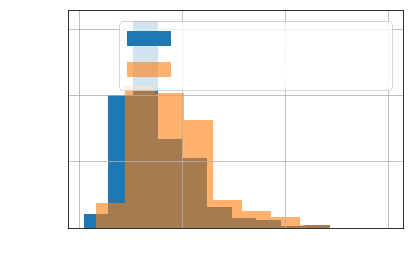

In [10]:
i_pm_before = pm_before[pm_before.corridor == "i"]
i_pm_after = pm_after[pm_after.corridor == "i"]
i_pm_before.rate.hist(density=True, label='before bus lane')
ax = i_pm_after.rate.hist(alpha=.6, density=True, label='after bus lane')
ax.legend()

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


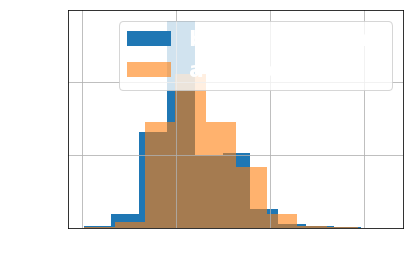

In [11]:
h_am_before = am_before[am_before.corridor == "h"]
h_am_after = am_after[am_after.corridor == "h"]
h_am_before.rate.hist(density=True, label='before bus lane')
ax = h_am_after.rate.hist(alpha=.6, density=True, label='after bus lane')
ax.legend()

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


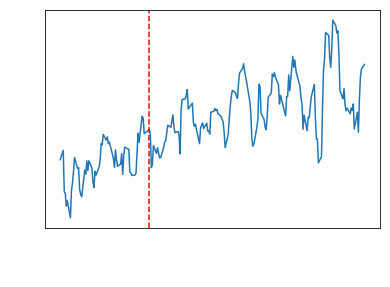

In [12]:
h_am_timeseries = pd.concat([h_am_before.groupby("days_since").rate.mean().sort_index(),
                h_am_after.groupby("days_since").rate.mean().sort_index()])
ax = h_am_timeseries.rolling(5).mean().plot()
ax.axvline(94, color='red', linestyle='dashed')

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


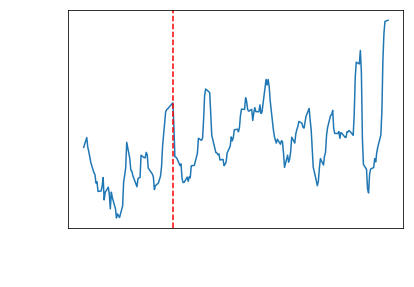

In [13]:
i_am_timeseries = pd.concat([i_pm_before.groupby("days_since").rate.mean().sort_index(),
                             i_pm_after.groupby("days_since").rate.mean().sort_index()])
ax = i_am_timeseries.rolling(5).mean().plot()
ax.axvline(94, color='red', linestyle='dashed')

/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


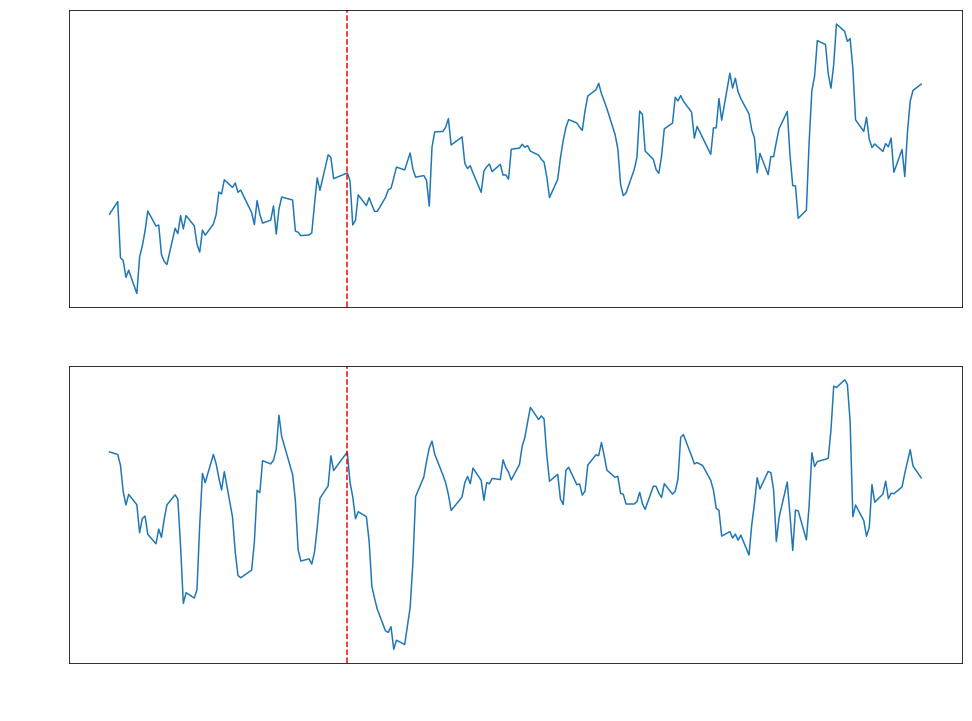

In [20]:
from datetime import timedelta 
grouped = [("am", am_only[am_only.corridor == 'h']), ("pm", pm_only[pm_only.corridor == 'h'])]
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
for (ix, group), ax in zip(grouped, axes):
    group.groupby("days_since").rate.mean().sort_index().rolling(5).mean().plot(ax=ax, label='avg bus speed, mph')
    ax.axvline(94, color='red', linestyle='dashed', label='Jun 3, day of rollout')
    ax.set_xlabel("{} rush hour, H street corridor, 5-day moving average".format(ix.upper()))
    min_start = [(pm_only.start_t.min() + timedelta(days=x)).strftime("%m-%d") for x in ax.get_xticks()]
    ax.set_xticklabels(min_start)
    ax.set_ylabel("Avg. speed (MPH)")


/home/christian/.miniconda2/envs/new_gpd_3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


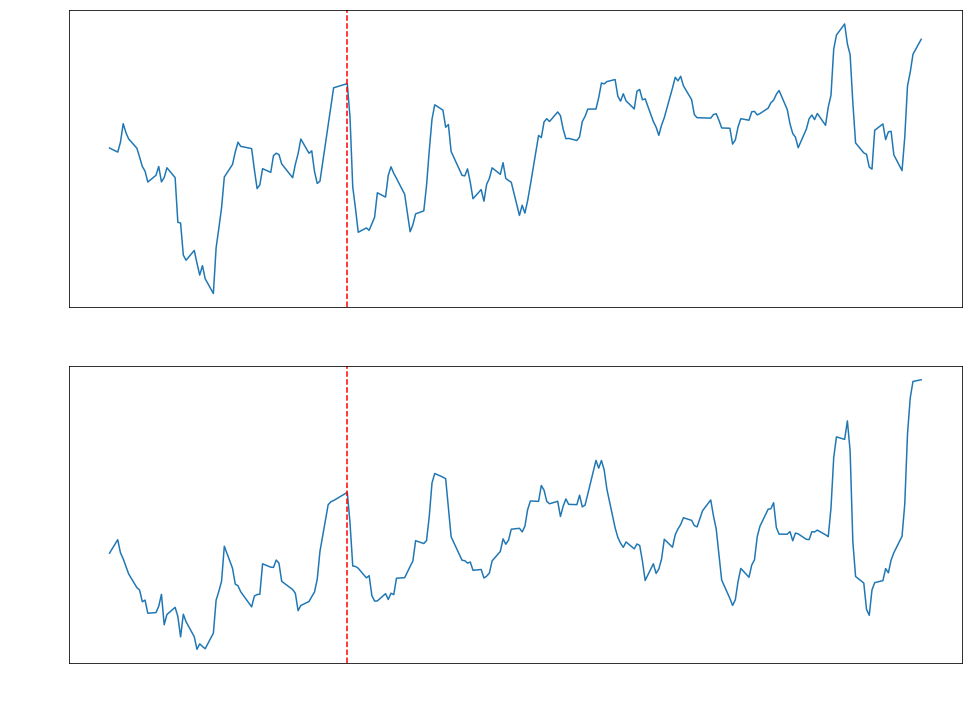

In [19]:
from datetime import timedelta 
grouped = [("am", am_only[am_only.corridor == 'i']), ("pm", pm_only[pm_only.corridor == 'i'])]
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
for (ix, group), ax in zip(grouped, axes):
    group.groupby("days_since").rate.mean().sort_index().rolling(5).mean().plot(ax=ax, label='avg bus speed, mph')
    ax.axvline(94, color='red', linestyle='dashed', label='Jun 3, day of rollout')
    ax.set_xlabel("{} rush hour, I street corridor, 5-day moving average".format(ix.upper()))
    min_start = [(pm_only.start_t.min() + timedelta(days=x)).strftime("%m-%d") for x in ax.get_xticks()]
    ax.set_xticklabels(min_start)
    ax.set_ylabel("Avg. speed (MPH)")
